<a href="https://colab.research.google.com/github/eroj333/learning-cv-ml/blob/master/SNN/Online%20Triplet%20Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras as k
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adadelta
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
# Load Fashion MNIST dataset
(x_train_master, y_train_master), (x_test_master, y_test_master) = k.datasets.fashion_mnist.load_data()
x_train_master = x_train_master /  255
x_test_master = x_test_master / 255

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
x_train_master.shape, x_test_master.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
x_train_master = np.expand_dims(x_train_master, 3)
x_test_master = np.expand_dims(x_test_master, 3)

In [0]:
y_train_master = np.expand_dims(y_train_master, 1)
y_test_master = np.expand_dims(y_test_master, 1)

In [0]:
num_train_per_class = 400
n_epochs = 200 + 1
batch_size = 20 # less is better
embedding_dim = 50  # output of the network
embeddings_freq = 100 # frequency to save tensorboard callback data 

In [0]:
def generate_classifier_data(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(10):
    pos_indices = np.argwhere(label == i)[:,0]

    # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    sub_x_anc = dataset[choice_anchor]
    
        
    if(x is None):
      x = sub_x_anc
      y = label[choice_anchor]
    else:
      x = np.vstack((x, (sub_x_anc)))

      y = np.hstack((y.flatten(), label[choice_anchor].flatten()))
    
  return x, y

In [0]:
# The hard triplets are computed for a batch. so, we need a generator
class BatchGenerator(k.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, embedding_dim):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = True

    def on_epoch_end(self):
        indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(indexes)
            self.x = self.x[indexes]
            self.y = self.y[indexes]

    def __len__(self):
        return int(np.ceil(len(self.y) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return [batch_x, batch_y], np.ones(batch_y.shape)

In [0]:
train_x, train_y = generate_classifier_data(x_train_master, y_train_master, num_train_per_class)


In [0]:
train_x.shape, train_y.shape

((4000, 28, 28, 1), (4000,))

In [0]:
batchGenerator = BatchGenerator(train_x.copy(), train_y.copy(), batch_size, embedding_dim)

In [0]:
"""Define functions to create the triplet loss with online triplet mining."""

import tensorflow as tf


def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask
  
def batch_hard_triplet_loss(labels, embeddings , margin=1, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)
    
    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)
    
    return triplet_loss



In [0]:
def get_loss_function(labels):
  def loss(y_true, y_pred):
    return batch_hard_triplet_loss(tf.squeeze(labels), y_pred , margin=10, squared=False)
  return loss

In [0]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)

In [0]:
"""
    Model architecture
"""
input_shape=x_train_master[0].shape
label_shape=(1,)
# Define the inputs to the network
img_inputs = Input(input_shape, name="img_input")
labels = Input(label_shape, name="label_input") # this will be used for calculating loss only

x = Flatten()(img_inputs)
x = Dense(embedding_dim * 4,activation="relu")(x)
x = Dense(embedding_dim * 2, activation='relu')(x)
encoded_inputs = Dense(embedding_dim, name="enc_op")(x)

# concat = Concatenate(axis=-1)([encoded_inputs, labels])
# print(concat.shape)

inputs = [img_inputs, labels]
outputs = encoded_inputs

# Connect the inputs with the outputs
siamese_model = Model(inputs=inputs,outputs=outputs)
encoding_model = Model(inputs=img_inputs, outputs=outputs)

In [0]:
# embedding_model, siamese_model = get_siamese_model(x_train_master[0].shape, (1,),batch_size, embedding_dim)

In [0]:
siamese_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
enc_op (Dense)               (None, 50)                5050      
Total params: 182,150
Trainable params: 182,150
Non-trainable params: 0
_________________________________________________________________


In [0]:
siamese_model.compile(loss=get_loss_function(labels), optimizer=Adam(0.0001))


Instructions for updating:
Use `tf.cast` instead.


In [0]:
tfb_test_callback = k.callbacks.TensorBoard(batch_size=batch_size, log_dir="./logs/test",
                                         embeddings_freq=embeddings_freq,  
                                         embeddings_layer_names=['enc_op'],  # Embeddings are taken from layers
                                         embeddings_metadata='metadata_test.tsv',  # This file will describe the embeddings data (see below)
                                         embeddings_data=[x_test_master, y_test_master])  # Data used for the embeddings

tfb_train_callback = k.callbacks.TensorBoard(batch_size=batch_size, log_dir="./logs/train",
                                         embeddings_freq=embeddings_freq,  
                                         embeddings_layer_names=['enc_op'],  # Embeddings are taken from layers
                                         embeddings_metadata='metadata_train.tsv',  # This file will describe the embeddings data (see below)
                                         embeddings_data=[train_x, train_y])  # Data used for the embeddings
callbacks = [tfb_train_callback, tfb_test_callback]

In [0]:
import os

if not os.path.exists('./logs'):
    os.makedirs('./logs')

# save class labels to disk to color data points in TensorBoard accordingly
with open(os.path.join("./logs", 'metadata_train.tsv'), 'w') as f:
    np.savetxt(f, train_y)

with open(os.path.join("./logs", 'metadata_test.tsv'), 'w') as f:
    np.savetxt(f, y_test_master)


In [0]:
# history = siamese_model.fit(x=classifier_train_x, y=k.utils.to_categorical(classifier_train_y), shuffle=True, batch_size=1000,
#                               validation_split=.1, epochs=n_epochs)

history = siamese_model.fit_generator(batchGenerator, epochs=n_epochs, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











Epoch 1/201
200/200 [==============================] - 2s 12ms/step - loss: 10.0000

Epoch 2/201
200/200 [==============================] - 2s 8ms/step - loss: 9.9102
Epoch 3/201
200/200 [==============================] - 2s 8ms/step - loss: 9.5397
Epoch 4/201
200/200 [==============================] - 2s 8ms/step - loss: 9.0435
Epoch 5/201
200/200 [==============================] - 2s 8ms/step - loss: 8.7302
Epoch 6/201
200/200 [==============================] - 2s 8ms/step - loss: 8.3474
Epoch 7/201
200/200 [==============================] - 2s 8ms/step - loss: 8.1759
Epoch 8/201
200/200 [==============================] - 1s 7ms/step - loss: 7.9027
Epoch 9/201
200/200 [==============================] - 1s 7ms/step - loss: 7.7136
Epoch 10/201
200/200 [==============================] - 1s 7ms/step - loss: 7.4492
Epoch 11/201
200/200 [==============================] - 1s 7ms/step - l

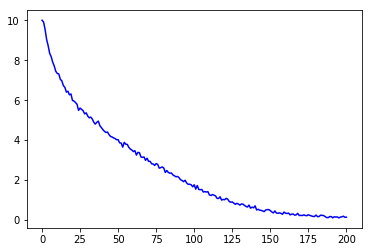

In [0]:
plt.plot(history.history["loss"], color="blue")

In [0]:
train_embeds = encoding_model.predict(train_x)

In [0]:
target = np.squeeze(train_y)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [0]:
classifier = fit_nearest_neighbor(train_embeds, target)

In [0]:
e = encoding_model.predict(x_test_master)
op = classifier.predict(e)

In [0]:
# classifier.score(e, y_test_master)
# target = y_test_master.flatten()
# (np.where(target == op))[0].shape

In [0]:
(np.where(np.squeeze(y_test_master) == op))[0].shape[0] / y_test_master.shape[0]

0.8358

In [0]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(np.squeeze(y_test_master) , op)

In [0]:
mat.diagonal()

array([774, 950, 729, 846, 738, 931, 608, 924, 920, 938])

In [0]:
!ls

logs  sample_data


In [0]:
# !rm SNN_logs.zip
!zip -r SNN_logs.zip ./logs/*

  adding: logs/metadata_test.tsv (deflated 96%)
  adding: logs/metadata_train.tsv (deflated 100%)
  adding: logs/test/ (stored 0%)
  adding: logs/test/keras_embedding.ckpt-0.data-00000-of-00001 (deflated 7%)
  adding: logs/test/keras_embedding.ckpt-0.meta (deflated 88%)
  adding: logs/test/checkpoint (deflated 68%)
  adding: logs/test/projector_config.pbtxt (deflated 16%)
  adding: logs/test/keras_embedding.ckpt-200.index (deflated 33%)
  adding: logs/test/keras_embedding.ckpt-200.data-00000-of-00001 (deflated 7%)
  adding: logs/test/keras_embedding.ckpt-100.data-00000-of-00001 (deflated 7%)
  adding: logs/test/keras_embedding.ckpt-200.meta (deflated 88%)
  adding: logs/test/keras_embedding.ckpt-100.meta (deflated 88%)
  adding: logs/test/keras_embedding.ckpt-100.index (deflated 33%)
  adding: logs/test/events.out.tfevents.1570676287.57ba76e31ccf (deflated 88%)
  adding: logs/test/keras_embedding.ckpt-0.index (deflated 33%)
  adding: logs/train/ (stored 0%)
  adding: logs/train/keras_e

Colab doesn't support projection at the time of writing. So, download the zip file and visualize in the local machine